In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

The aim is to build a model which can predict the 'volume' (popularity) of a keyword, based on several predictors.

The first step is to create training and validation datasets which can be used to train and validate models. To do this: 
* the datasets will have any NaNs set to -1
* the 'keyword' column will be dropped so the model can accept any keywords
* each of the five country datasets will have 15% of the dataset sampled to become the validation dataset
* the remaining 85% will be the training dataset

The datasets are then split into x_train, x_val, y_train, y_val, where y is the volume value and x is the other columns which will be used to make predictions.

The x datasets are normalised by subtracting the training mean and dividing by the training standard deviation. This gives the dataset a mean of 0 and standard deviation of 1. The scaler used to normalise is saved so it can be used to normalise any test cases.

The datasets are saved so that all models can use the same datasets.

In [3]:
sns.set(context='notebook', style='darkgrid')

## Load Data

In [4]:
# load data and add country column
ar_df = pd.read_csv('data/volume_by_keyword_ar.csv')
ar_df['Country']='ar'
be_df = pd.read_csv('data/volume_by_keyword_be.csv')
be_df['Country']='be'
ie_df = pd.read_csv('data/volume_by_keyword_ie.csv')
ie_df['Country']='ie'
jp_df = pd.read_csv('data/volume_by_keyword_jp.csv')
jp_df['Country']='jp'
kr_df = pd.read_csv('data/volume_by_keyword_kr.csv')
kr_df['Country']='kr'

In [5]:
# check shapes of dataframes
datasets = [ar_df, be_df, ie_df, jp_df, kr_df]
for dataset in datasets:
    print(dataset.shape)

(2649, 14)
(3274, 14)
(2472, 14)
(2330, 14)
(3140, 14)


In [6]:
# combine datasets
train_val = pd.concat(datasets)
train_val.shape

(13865, 14)

## Check correlations and plot variables

In [7]:
# check correlations
train_val.corr()

,Wingardium_score,Wingardium_Leviosa,Wingardium_empty,top1_Wingardium,top2_Wingardium,top3_Wingardium,top4_Wingardium,top5_Wingardium,Alohomora_score,Alohomora_Leviosa,Alohomora_empty,volume
Wingardium_score,1.000000,-0.184378,NaN,0.921749,0.185796,0.165749,0.178241,0.192931,0.721093,-0.159950,0.003953,0.503684
Wingardium_Leviosa,-0.184378,1.000000,NaN,0.001352,0.167508,0.201191,0.220656,0.223891,-0.081981,0.629745,-0.177273,-0.078135
Wingardium_empty,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.009488,-0.034228,0.740754,-0.470182
top1_Wingardium,0.921749,0.001352,NaN,1.000000,0.650498,0.549409,0.501663,0.466695,0.527747,0.007267,0.061771,0.349188
top2_Wingardium,0.185796,0.167508,NaN,0.650498,1.000000,0.793532,0.693387,0.619935,0.213622,0.090620,0.066818,0.343274
top3_Wingardium,0.165749,0.201191,NaN,0.549409,0.793532,1.000000,0.853722,0.755679,0.177365,0.106223,0.077618,0.332053
top4_Wingardium,0.178241,0.220656,NaN,0.501663,0.693387,0.853722,1.000000,0.869995,0.170452,0.123850,0.074543,0.320963
top5_Wingardium,0.192931,0.223891,NaN,0.466695,0.619935,0.755679,0.869995,1.000000,0.170742,0.131964,0.083457,0.323568
Alohomora_score,0.721093,-0.081981,0.009488,0.527747,0.213622,0.177365,0.170452,0.170742,1.000000,-0.298494,NaN,0.590547
Alohomora_Leviosa,-0.159950,0.629745,-0.034228,0.007267,0.090620,0.106223,0.123850,0.131964,-0.298494,1.000000,NaN,-0.185086


In [8]:
train_val.describe()

,Wingardium_score,Wingardium_Leviosa,top1_Wingardium,top2_Wingardium,top3_Wingardium,top4_Wingardium,top5_Wingardium,Alohomora_score,Alohomora_Leviosa,volume
count,5652.000000,5652.000000,9004.000000,7089.000000,6191.000000,5638.000000,5246.000000,3058.000000,3058.000000,13865.000000
mean,6.841720,0.774085,6.248533,5.829995,5.620218,5.509308,5.381509,6.765115,0.752961,17.198846
std,0.210061,0.160479,1.787331,2.180689,2.311437,2.364680,2.444058,0.290253,0.134490,17.653920
min,5.846852,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,5.846852,0.693147,5.000000
25%,6.849672,0.693147,6.849672,5.862006,5.848501,5.847677,5.847264,6.849672,0.693147,5.000000
50%,6.849975,0.693147,6.849975,6.849672,6.849672,6.489422,6.488988,6.849672,0.693147,6.000000
75%,6.858265,0.847298,6.862758,6.851487,6.850126,6.849823,6.849823,6.850580,0.693147,27.000000
max,7.475015,1.609438,7.475015,7.291364,7.258412,7.248606,7.152269,7.333583,1.609438,100.000000


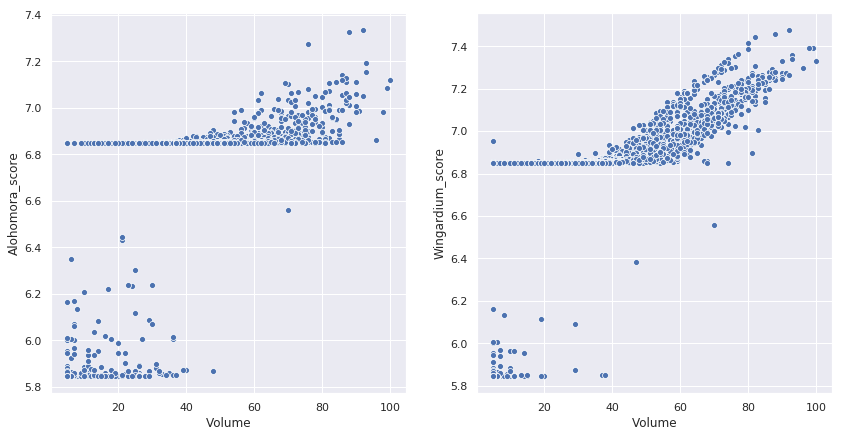

In [9]:
# plot Alohomora_score and Wingardium_score against volumes
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=train_val['volume'].values, y=train_val['Alohomora_score'].values)
plt.xlabel('Volume')
plt.ylabel('Alohomora_score')

plt.subplot(1, 2, 2)
sns.scatterplot(x=train_val['volume'].values, y=train_val['Wingardium_score'].values)
plt.xlabel('Volume')
plt.ylabel('Wingardium_score')

plt.show()

## Check and replace NaNs

In [8]:
# check how many NaNs
train_val.isna().sum()

keyword                   0
Wingardium_score       8213
Wingardium_Leviosa     8213
Wingardium_empty          0
top1_Wingardium        4861
top2_Wingardium        6776
top3_Wingardium        7674
top4_Wingardium        8227
top5_Wingardium        8619
Alohomora_score       10807
Alohomora_Leviosa     10807
Alohomora_empty           0
volume                    0
Country                   0
dtype: int64

In [9]:
# replace NaNs with -1
train_val = train_val.fillna(-1)
# set True to 1 and set False to 0
train_val *= 1

In [10]:
# check how dataset looks
train_val

,keyword,Wingardium_score,Wingardium_Leviosa,Wingardium_empty,top1_Wingardium,top2_Wingardium,top3_Wingardium,top4_Wingardium,top5_Wingardium,Alohomora_score,Alohomora_Leviosa,Alohomora_empty,volume,Country
0,app,-1.000000,-1.000000,0,6.964271,6.913595,6.893801,6.879944,6.877001,-1.000000,-1.000000,0,35,ar
1,free apps,-1.000000,-1.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0,5,ar
2,free app,-1.000000,-1.000000,0,5.981775,5.930728,5.854253,5.846852,5.846852,-1.000000,-1.000000,0,9,ar
3,free apps for iphone,-1.000000,-1.000000,1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,5,ar
4,iphone apps,-1.000000,-1.000000,0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,5,ar
5,phone app,-1.000000,-1.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0,5,ar
6,popular apps,-1.000000,-1.000000,0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,5,ar
7,top apps,5.847264,0.980829,0,5.876134,5.847677,5.847264,5.846852,0.000000,-1.000000,-1.000000,0,5,ar
8,top free apps,-1.000000,-1.000000,0,5.855072,5.850559,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,5,ar
9,gratix,6.849672,0.693147,0,6.849672,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,5,ar


## Create train and validation sets, sampling evenly for each country

In [11]:
# sample from each country dataset evenly
countries = ['ar', 'be', 'ie', 'jp', 'kr']
train_l = []
val_l = []
for country in countries:
    current_ds = train_val[train_val['Country'] == country]
    train, val = train_test_split(current_ds, test_size=0.15)
    train_l.append(train)
    val_l.append(val)

In [12]:
# create train, val datasets
train = pd.concat(train_l)
val = pd.concat(val_l)

## Drop columns

In [13]:
# the model must be able to accept any word
# therefore, drop keyword column
# drop country column
train = train.drop(columns=['Country', 'keyword'])
val = val.drop(columns=['Country', 'keyword'])

## Create x_train, y_train, x_val, y_val

In [14]:
y_train = train.pop('volume')
x_train = train.copy()

y_val = val.pop('volume')
x_val = val.copy()

## Normalise the data

In [280]:
scaler = StandardScaler()
cols_to_standard = ['Wingardium_score',
                    'Wingardium_Leviosa',
                    'top1_Wingardium',
                    'top2_Wingardium',
                    'top3_Wingardium',
                    'top4_Wingardium',
                    'top5_Wingardium',
                    'Alohomora_score',
                    'Alohomora_Leviosa']
# calculate mean and stdd from training data 
scaler.fit(x_train[cols_to_standard])
# normalise x_train
x_train[cols_to_standard] = scaler.transform(x_train[cols_to_standard])
# normalise x_val
x_val[cols_to_standard] = scaler.transform(x_val[cols_to_standard])

In [281]:
# save scaler
joblib.dump(scaler, 'model/scaler.pkl') 

['model/scaler.pkl']

## Save the data

In [282]:
y_train.to_csv('data/y_train.csv', index=False, header=['volume'])
x_train.to_csv('data/x_train.csv', index=False)
y_val.to_csv('data/y_val.csv', index=False, header=['volume'])
x_val.to_csv('data/x_val.csv', index=False)